In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib import colormaps
from pathlib import Path
import rerun as rr
from b3d.utils import keysplit


key = jax.random.PRNGKey(0)

In [3]:
from b3d.chisight.sfm.datasets import TumRgbdData


root = Path("/home/mirkoklukas/workspace/data/rgbd_slam_dataset_freiburg")
datasets = TumRgbdData._show_available_datasets(root)

Available datasets in /home/mirkoklukas/workspace/data/rgbd_slam_dataset_freiburg/...:
(0) rgbd_dataset_freiburg3_sitting_static
(1) rgbd_dataset_freiburg1_xyz
(2) rgbd_dataset_freiburg3_long_office_household


Sequence rgbd_dataset_freiburg3_long_office_household already exists.
Num Frames: 2585


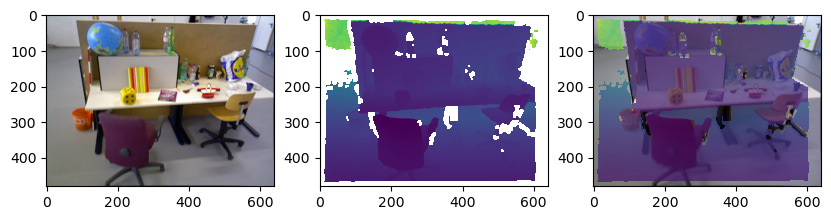

In [4]:
# sequence_name = datasets[0]
sequence_name = "rgbd_dataset_freiburg3_long_office_household"

# Download the sequence
sequence_url = TumRgbdData._sequence_url_from_sequence_name(sequence_name)
sequence_folder = TumRgbdData._download_from_url(sequence_url, root)
path = root/sequence_name
data = TumRgbdData(path)

# Get the i'th RGB image
# Note that rgb, depth, and pose sequences are not synchronized, so the i'th RGB image
# and the i'th depth image and pose are not guaranteed to be from the same time.
i = 100
rgb = data.get_rgb(i)

print(f"Num Frames: {len(data)}")

# This returns i'th RGB image and the CLOSEST (in time) available depth image and pose
rgb, depth, pose = data.get_synced(i)
# ==============================================
# Plot the RGB and depth images side by side
fig, axs = plt.subplots(1, 3, figsize=(10,5))
axs[0].imshow(rgb)
axs[1].imshow(np.where(depth>0, depth, np.nan))
axs[2].imshow(rgb, alpha=1.)
axs[2].imshow(np.where(depth>0, depth, np.nan), alpha=0.75);

In [5]:
from b3d.chisight.sfm.utils import (
    rescale_pose,
    rescale_poses,
    reproject_using_depth,
    xq_dist,
    xq_cos,
    vmap_uniform_pose,
    vals_from_im,
)
from b3d.chisight.sfm.plotting_utils import (
    log_pose,
)
from b3d.chisight.sfm.opencv_wrapper import (
    matched_only_sift as matched_sift_cv,
    detect_and_match_sift as detect_and_match_sift_cv,
    recover_pose,
    find_essential,
    infer_pose as infer_pose_cv,
    infer_pose_and_inlier as infer_pose_and_inlier_cv,
    detect_sift,
    detect_orb,
    match_bf,
)
from b3d.chisight.sfm.eight_point import (
    normalized_eight_point,
    normalized_eight_point_with_constraints,
    find_best_chirality,
    poses_from_essential,
    essential_from_pose,
    essential_constraints,
    enforce_internal_constraint,
    triangulate_linear_hartley,
)
from b3d.chisight.sfm.epipolar import( 
    epipolar_image_distances,
)
from b3d.pose import Pose

from b3d.camera import (
    Intrinsics, 
    camera_matrix_from_intrinsics, 
    camera_from_screen, 
    screen_from_camera,
    screen_from_world,
)

import cv2


intr  = Intrinsics.from_array(data.get_intrinsics())
cam_K = camera_matrix_from_intrinsics(intr)
cam_K_inv = jnp.linalg.inv(cam_K)

intr = Intrinsics(*data.get_intrinsics()[:-2], 0.1, 10.)

In [30]:
def camera_angle(p0, p1=Pose.id()):
    return jnp.dot(
        p0.rot.as_matrix()[:,2],
        p1.rot.as_matrix()[:,2]
    )

In [35]:
def rgb_to_gray_uint8(rgb):
    v = jnp.array([0.2125, 0.7154, 0.0721 ])
    return np.array(jnp.dot(rgb[...,:3], v)).astype(np.uint8)


      Pos  diff   0.05, 
      Quat diff   0.02



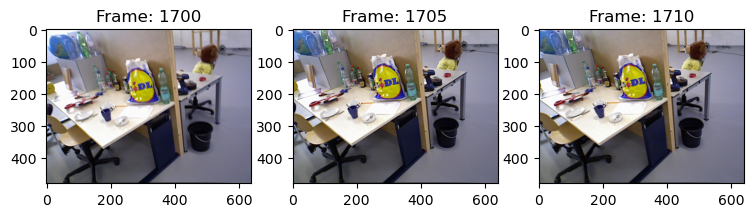

In [24]:
t0 = [1280, 1700, 1500, 1200, 600, 150, 40, 350][1] 
dt = 5
t1 = t0 + dt
t2 = t1 + dt


rgb, depth, cams = data[[t0, t1, t2]]
# ==============================================
print(f"""
      Pos  diff  {xq_dist(cams[0], cams[1])[0]:>5.2f}, 
      Quat diff  {xq_dist(cams[0], cams[1])[1]:>5.2f}
""")
data.plot_multiple_frames([t0,t1,t2], axs=None);

In [25]:
data.get_timestamp(t1) - data.get_timestamp(t0)

for c, c_ in zip(cams[:-1], cams[1:]):
    ang = camera_angle(c, c_)
    dx, dq  = xq_cos(c, c_)
    print(f"{ang:0.3f} {dx:0.3f} {dq:0.3f}"),

# Convert timestamp to ms
print(f"""
    dt0 = {data.get_timestamp(t1) * 1000 - data.get_timestamp(t0) * 1000: 0.1f} ms ~ {1000/(data.get_timestamp(t1) * 1000 - data.get_timestamp(t0) * 1000): <0.0f} FPS
    dt1 = {data.get_timestamp(t2) * 1000 - data.get_timestamp(t1) * 1000: 0.1f} ms ~ {1000/(data.get_timestamp(t2) * 1000 - data.get_timestamp(t1) * 1000): <.0f} FPS
     
""")

0.999 1.000 1.000
1.000 1.000 1.000

    dt0 =  167.9 ms ~ 6 FPS
    dt1 =  175.1 ms ~ 6 FPS
     



In [40]:
t0 = 1700

rgb0,_,cam0 = data[t0]
# rgb0 = rgb_to_gray_uint8(rgb0)
uvs0, fs0 = detect_sift(rgb0)
# uvs0, fs0 = detect_orb(rgb0, 10_000)

xs_true, cs_true, _ = data._get_colored_world_points(t0)

# =============
rr.init("SfM")
rr.connect("127.0.0.1:8812")
rr.set_time_sequence("frame_idx", 0)

radii = .01
rr.log(f"World_true", rr.Points3D(xs_true, colors=cs_true, radii=radii/2))

In [46]:
dt = 20
steps = 10
num_matches = []
num_inliers = []
ps = [Pose.id()]
cams = [cam0]
for i,t1 in enumerate(np.arange(t0, t0 + steps*dt, step=dt)[1:]):
    rgb1, _ , cam1 = data[int(t1)]
    # rgb1 = rgb_to_gray_uint8(rgb1)

    uvs1, fs1 = detect_sift(rgb1)
    # uvs1, fs1 = detect_orb(rgb1, 10_000)
    inds = match_bf(fs0, fs1, thresh=0.75)

    num_matches.append(len(inds))

    p1, inlier = infer_pose_and_inlier_cv(uvs0[inds[:,0]], uvs1[inds[:,1]], cam_K, prob=.9999, threshold=1.0, max_iters=1000)
    num_inliers.append(inlier.sum())

    ps.append(p1)
    cams.append(cam1)

    print(len(inds), inlier.sum(), f"{num_inliers[-1]/num_matches[-1]:0.2f}")

    rr.set_time_sequence("frame_idx", i)
    rr.log("img", rr.Image(jnp.concatenate([rgb0,rgb1], axis=1)))
    rr.log("img/0_all", rr.Points2D(uvs0[:], colors=[1.,1.,1.], radii=[2.]))
    rr.log("img/0", rr.Points2D(uvs0[inds[:,0]], colors=[1.,0,1.], radii=[4.]))
    rr.log("img/1_all", rr.Points2D(uvs1[:] + np.array([rgb0.shape[1], 0]), colors=[1.,1.,1.], radii=[2.]))
    rr.log("img/1", rr.Points2D(uvs1[inds[:,1]] + np.array([rgb0.shape[1], 0]), colors=[1.,0,1.], radii=[4.]))

ps = Pose.stack_poses(ps)
cams = Pose.stack_poses(cams)



rr.set_time_sequence("frame_idx", 0)
# =============
for i,(p,c) in enumerate(zip(ps[1:], cams[1:])):

    p = rescale_pose(p, cams[0].inv()@c)

    log_pose(f"Poses_True/c[{i}]", c, scale=.15, c=np.array([0.,1.,0.]))
    log_pose(f"Poses/p[{i}]", cams[0]@p, scale=.25, c=np.array([1.,0.,0.]))

255 181 0.71
113 85 0.75
85 46 0.54
33 13 0.39
46 21 0.46
44 14 0.32
28 13 0.46
21 8 0.38
20 8 0.40


In [ ]:
dt = 20
steps = 6
num_matches = []
ps = [Pose.id()]
cams = [cam0]
for i,t1 in enumerate(np.arange(t0, t0 + steps*dt, step=dt)[1:]):
    rgb1, _ , cam1 = data[int(t1)]

    uvs1, fs1 = detect_sift(rgb1)
    # uvs1, fs1 = detect_orb(rgb1, 10_000)
    inds = match_bf(fs0, fs1, thresh=0.75)

    print(len(inds))
    num_matches.append(len(inds))

    p1, inlier = infer_pose_and_inlier_cv(uvs0[inds[:,0]], uvs1[inds[:,1]], cam_K, prob=.9999, threshold=1.0, max_iters=1000)
    ps.append(p1)
    cams.append(cam1)

    rr.set_time_sequence("frame_idx", i)
    rr.log("img", rr.Image(jnp.concatenate([rgb0,rgb1], axis=1)))
    rr.log("img/0_all", rr.Points2D(uvs0[:], colors=[1.,1.,1.], radii=[2.]))
    rr.log("img/0", rr.Points2D(uvs0[inds[:,0]], colors=[1.,0,1.], radii=[4.]))
    rr.log("img/1_all", rr.Points2D(uvs1[:] + np.array([rgb0.shape[1], 0]), colors=[1.,1.,1.], radii=[2.]))
    rr.log("img/1", rr.Points2D(uvs1[inds[:,1]] + np.array([rgb0.shape[1], 0]), colors=[1.,0,1.], radii=[4.]))

ps = Pose.stack_poses(ps)
cams = Pose.stack_poses(cams)



rr.set_time_sequence("frame_idx", 0)
# =============
for i,(p,c) in enumerate(zip(ps[1:], cams[1:])):

    p = rescale_pose(p, cams[0].inv()@c)

    log_pose(f"Poses_True/c[{i}]", c, scale=.15, c=np.array([0.,1.,0.]))
    log_pose(f"Poses/p[{i}]", cams[0]@p, scale=.25, c=np.array([1.,0.,0.]))

In [15]:
num_matches, camera_angle(ps[1:], ps[0])

([337, 255, 172, 113, 85],
 Array([0.9976413, 0.9980565, 0.9921926, 0.9896291, 0.9812602], dtype=float32))

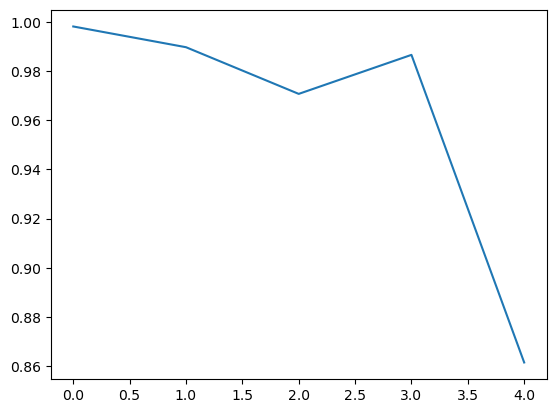

In [34]:
plt.plot(camera_angle(ps[1:], ps[0]))

In [ ]:
for c, c_ in zip(ps[:-1], ps[1:]):
    ang = camera_angle(c, c_)
    dx, dq  = xq_cos(c, c_)
    print(f"{ang:0.3f} {dx:0.3f} {dq:0.3f}"),

[1399, 290, 106, 66, 56, 40, 44, 49, 39, 39]

0.983 0.992 0.995
0.946 0.994 0.980

    dt0 =  1676.0 ms ~ 1 FPS
    dt1 =  1708.0 ms ~ 1 FPS
     



In [180]:
def debug_camera_constelation(cams):
    ang    = jax.vmap(jax.vmap(camera_angle, (0, None)), (None, 0))(cams, cams)
    cos_x, cos_q = jax.vmap(jax.vmap(xq_cos, (0, None)), (None, 0))(cams, cams)
    dist_x, dist_q = jax.vmap(jax.vmap(xq_dist, (0, None)), (None, 0))(cams, cams)

    print(ang)

    print(cos_x)
    print(cos_q)
    print(dist_x)
    print(dist_q)

debug_camera_constelation(cams)

[[1.0000001 0.9998252 0.9994008]
 [0.9998252 1.0000002 0.9998669]
 [0.9994008 0.9998669 1.0000002]]
[[1.         0.9999899  0.99995434]
 [0.9999899  1.0000001  0.99998724]
 [0.99995434 0.99998724 1.        ]]
[[1.0000001  0.99995255 0.999839  ]
 [0.99995255 1.0000001  0.99996483]
 [0.999839   0.99996483 1.0000002 ]]
[[0.         0.01692355 0.03603393]
 [0.01692355 0.         0.01912436]
 [0.03603393 0.01912436 0.        ]]
[[0.         0.00975445 0.01794886]
 [0.00975445 0.         0.00840594]
 [0.01794886 0.00840594 0.        ]]


In [181]:
def rgb_to_gray_uint8(rgb):
    v = jnp.array([0.2125, 0.7154, 0.0721 ])
    return np.array(jnp.dot(rgb[...,:3], v)).astype(np.uint8)

10.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

uvs:
    (1000, 2) (1000, 32)
    (1000, 2) (1000, 32)
    (1000, 2) (1000, 32)
inds:
    (21, 2) (16, 2)
    (1, 3)



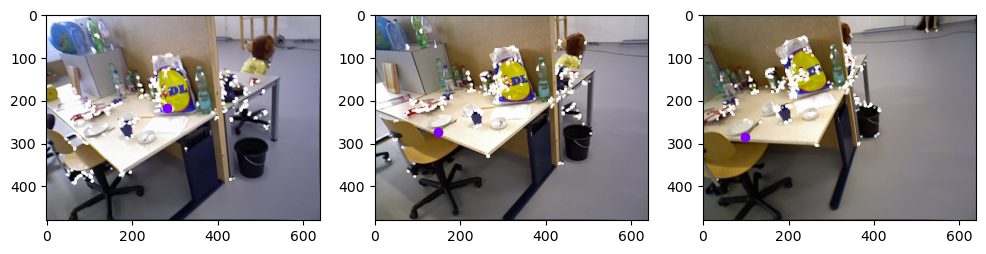

In [17]:
"""ORB"""

def rgb_to_gray(rgb):
    v = jnp.array([0.2125, 0.7154, 0.0721 ])
    return np.array(jnp.dot(rgb[...,:3], v)).astype(np.uint8)

uvs0, fs0 = detect_orb(rgb[0], 1_000)
uvs1, fs1 = detect_orb(rgb[1], 1_000)
uvs2, fs2 = detect_orb(rgb[2], 1_000)
# uvs0, fs0 = detect_orb(rgb_to_gray(rgb[0]), 1_000)
# uvs1, fs1 = detect_orb(rgb_to_gray(rgb[1]), 1_000)
# uvs2, fs2 = detect_orb(rgb_to_gray(rgb[2]), 1_000)
%timeit -n 1 -r 1 detect_orb(rgb[0])

inds01 = match_sift(fs0, fs1)
inds12 = match_sift(fs1, fs2)
inds02 = match_sift(fs0, fs2)

triplets = []
for ij in inds01:
    k = np.where(inds12[:,0] == ij[1])[0]
    if len(k) > 0:
        k = k[0]
        assert inds12[k,0] == ij[1]
        triplets.append((ij[0], ij[1], inds12[k,1]))

triplets = np.array(triplets)

print(f"""
uvs:
    {uvs0.shape} {fs0.shape}
    {uvs1.shape} {fs1.shape}
    {uvs2.shape} {fs2.shape}
inds:
    {inds01.shape} {inds12.shape}
    {triplets.shape}
""")


# ==============================================
fig, axs = plt.subplots(1,3,figsize=(12,5))

cs = uvs0[triplets[:,0], 1]

ax = axs[0]
ax.imshow(rgb[0])
ax.scatter(uvs0[:,0] , uvs0[:,1], c="w", s=1, alpha=0.5)
ax.scatter(uvs0[triplets[:,0],0] , uvs0[triplets[:,0],1], c=cs, cmap="rainbow")


ax = axs[1]
ax.imshow(rgb[1])
ax.scatter(uvs1[:,0] , uvs1[:,1], c="w", s=1, alpha=0.5)
ax.scatter(uvs1[triplets[:,1],0] , uvs1[triplets[:,1],1], c=cs, cmap="rainbow")

ax = axs[2]
ax.imshow(rgb[2])
ax.scatter(uvs2[:,0] , uvs2[:,1], c="w", s=1, alpha=0.5)
ax.scatter(uvs2[triplets[:,2],0] , uvs2[triplets[:,2],1], c=cs, cmap="rainbow")

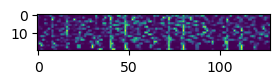

In [182]:
plt.figure(figsize=(3,1))
plt.imshow(fs0[:20])

54.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

uvs:
    (1032, 2) (1032, 128)
    (1403, 2) (1403, 128)
    (663, 2) (663, 128)
inds:
    (85, 2) (169, 2)
    (18, 3)



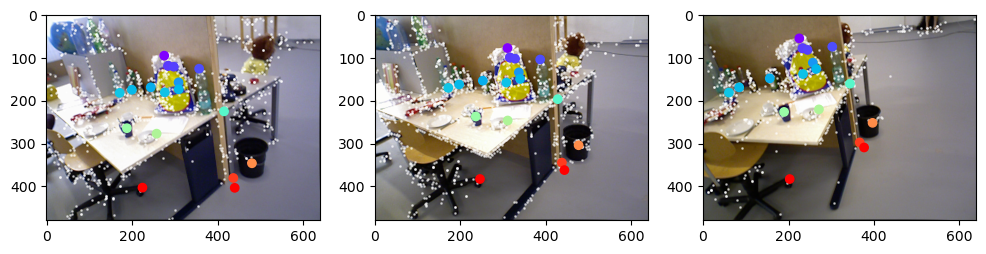

In [198]:
"""SIFT"""

uvs0, fs0 = detect_sift(rgb[0])
uvs1, fs1 = detect_sift(rgb[1])
uvs2, fs2 = detect_sift(rgb[2])

%timeit -n 1 -r 1 detect_sift(rgb[0])

inds01 = match_sift(fs0, fs1)
inds12 = match_sift(fs1, fs2)
inds02 = match_sift(fs0, fs2)


triplets = []
for ij in inds01:
    k = np.where(inds12[:,0] == ij[1])[0]
    if len(k) > 0:
        k = k[0]
        assert inds12[k,0] == ij[1]
        triplets.append((ij[0], ij[1], inds12[k,1]))

triplets = np.array(triplets)



print(f"""
uvs:
    {uvs0.shape} {fs0.shape}
    {uvs1.shape} {fs1.shape}
    {uvs2.shape} {fs2.shape}
inds:
    {inds01.shape} {inds12.shape}
    {triplets.shape}
""")

# ==============================================
fig, axs = plt.subplots(1,3,figsize=(12,5))

cs = uvs0[triplets[:,0], 1]

ax = axs[0]
ax.imshow(rgb[0])
ax.scatter(uvs0[:,0] , uvs0[:,1], c="w", s=1, alpha=0.5)
ax.scatter(uvs0[triplets[:,0],0] , uvs0[triplets[:,0],1], c=cs, cmap="rainbow")


ax = axs[1]
ax.imshow(rgb[1])
ax.scatter(uvs1[:,0] , uvs1[:,1], c="w", s=1, alpha=0.5)
ax.scatter(uvs1[triplets[:,1],0] , uvs1[triplets[:,1],1], c=cs, cmap="rainbow")

ax = axs[2]
ax.imshow(rgb[2])
ax.scatter(uvs2[:,0] , uvs2[:,1], c="w", s=1, alpha=0.5)
ax.scatter(uvs2[triplets[:,2],0] , uvs2[triplets[:,2],1], c=cs, cmap="rainbow")

In [192]:
u = jnp.zeros(2)
sigma=1.
jax.scipy.stats.norm.logpdf(u, loc=u, scale=sigma)


z = jax.random.uniform(key, minval=0.1, maxval=10.)
z

Array(9.3071375, dtype=float32)

In [318]:
from b3d.chisight.sfm.particle_inference import (
    single_view_posterior_sample, 
    single_view_score
)
import cv2


p1, inlier = infer_pose_and_inlier_cv(uvs0[inds01[:,0]], uvs1[inds01[:,1]], cam_K, prob=.9999, threshold=1.0, max_iters=1000)
p1 = rescale_pose(p1, cams[0].inv()@cams[1])

ys0 = camera_from_screen(uvs0[triplets[:,0]], intr)
ys1 = camera_from_screen(uvs1[triplets[:,1]], intr)
xs = triangulate_linear_hartley(Pose.id(), p1, ys0, ys1)


_, rot, trans, inlier = cv2.solvePnPRansac(np.array(xs), np.array(uvs2[triplets[:,2]]), np.array(cam_K), None, 
                                           iterationsCount=1_000, reprojectionError=2.01, confidence=0.99999, flags=cv2.SOLVEPNP_SQPNP)  


R = cv2.Rodrigues(rot)[0]
p2 = Pose.from_pos_matrix(trans[:,0], R).inv()


print(triplets.shape, xs.shape)

key, keys = keysplit(key, 1, 10_000)

single_view_posterior_samples = jax.vmap(single_view_posterior_sample, (0, None, None, None, None))
single_view_scores = jax.vmap(single_view_score, (0, None, None, None, None))


sigma = 2.
ss, logps = single_view_posterior_samples(keys, uvs0[triplets[:,0]], pose.id(), sigma, intr)
print(ss.shape, logps.shape)



xs_true, cs_true, _ = data._get_colored_world_points(t0)

# =============
rr.init("SfM")
rr.connect("127.0.0.1:8812")
rr.set_time_sequence("frame_idx", 0)


radii = .01

rr.log(f"World_true", rr.Points3D(xs_true, colors=cs_true, radii=radii/2))
log_pose("Pose[0]", cams[0], scale=.25, c=np.array([1.,0.,0.]))
log_pose("Pose[1]", cams[0]@p1, scale=.25, c=np.array([1.,0.,0.]))
log_pose("Pose[2]", cams[0]@p2, scale=.25, c=np.array([1.,0.,0.]))


rr.log(f"Triangulated", rr.Points3D(cams[0](xs), colors=np.array([1.,0.,0.]), radii=radii))

# rr.log(f"Posterior", rr.Points3D(cams[0](ss.reshape(-1,3)), colors=np.array([1.,0.,0.]), radii=radii))
# # rr.log(f"Triangulated_2", rr.Points3D(cams[0](xs02), colors=cs02, radii=radii))
# # rr.log(f"Triangulated_3", rr.Points3D(cams[0](p1(xs12)), colors=cs12, radii=radii))


# perm = jnp.argsort(ss[:,:,2], axis=0)
# logps = logps[perm, jnp.arange(logps.shape[1])]
# ss = ss[perm, jnp.arange(ss.shape[1])]

# logps = logps +\
#     single_view_scores(ss, p1, uvs1[triplets[:,1]], sigma, intr) +\
#     single_view_scores(ss, p2, uvs2[triplets[:,2]], sigma, intr)

# # logps = logps +\
#     # single_view_scores(ss, p2, uvs2[triplets[:,2]], sigma, intr)



# perm = jnp.argsort(logps, axis=0)
# logps = logps[perm, jnp.arange(logps.shape[1])]
# ss = ss[perm, jnp.arange(ss.shape[1])]

# rr.log(f"Posterior2", rr.Points3D(cams[0](ss[-100:].reshape(-1,3)), colors=np.array([1.,0.,0.]), radii=radii))


# # print(jnp.exp(logps).min(), jnp.exp(logps).max())

(18, 3) (18, 3)
(10000, 18, 3) (10000, 18)


In [319]:
def loss_func(params, uvs0, uvs1, uvs2):
    xs = params['xs']
    p1 = params['p1']
    p2 = params['p2']
    uvs0_ = screen_from_world(xs, Pose.id(), intr)
    uvs1_ = screen_from_world(xs, p1, intr)
    uvs2_ = screen_from_world(xs, p2, intr)
    return jnp.mean(jnp.array([
        jnp.linalg.norm(uvs0 - uvs0_, axis=-1).mean(),
        jnp.linalg.norm(uvs1 - uvs1_, axis=-1).mean(),
        jnp.linalg.norm(uvs2 - uvs2_, axis=-1).mean()]))

grad_func = jax.jit(jax.grad(loss_func))


params = {
    'xs': xs,
    'p1': p1,
    'p2': p2,
}
loss_func(params, uvs0[triplets[:,0]], uvs1[triplets[:,1]], uvs2[triplets[:,2]])

params

{'xs': Array([[-0.60125184, -0.23487715,  2.1278439 ],
        [-0.37959412,  0.07070539,  1.5149832 ],
        [-0.5005702 , -0.27428022,  2.1905081 ],
        [-0.35622388,  0.6158853 ,  1.9696808 ],
        [-0.2832395 , -0.26611882,  1.9654424 ],
        [-0.16896954,  0.10696565,  1.4416989 ],
        [-0.12687188, -0.41600266,  1.5130829 ],
        [-0.13132817, -0.18164654,  1.6120073 ],
        [-0.10347881, -0.3587834 ,  1.5577767 ],
        [-0.10330915, -0.3584422 ,  1.5581876 ],
        [-0.06442627, -0.35248604,  1.5623889 ],
        [-0.03265861, -0.25230306,  1.5947698 ],
        [-0.03067807, -0.19958934,  1.576554  ],
        [ 0.10640628, -0.32306594,  1.4851404 ],
        [ 0.3070698 , -0.04617052,  1.6809161 ],
        [ 0.45457897,  0.5483641 ,  2.0237644 ],
        [ 0.45143464,  0.61384684,  1.962519  ],
        [ 0.5797102 ,  0.3814028 ,  1.8927338 ]], dtype=float32),
 'p1': Pose(position=Array([-0.437488  ,  0.1217299 , -0.07390501], dtype=float32), quaternion=

In [326]:
import optax



# df = jax.grad(f, )

# f(xs, Pose.id(), p1, p2, uvs0[triplets[:,0]], uvs1[triplets[:,1]], uvs2[triplets[:,2]])

# optimizer = optax.adam(1e-2)
# params = {
#     'xs': 0.1*jax.random.normal(key, (xs.shape[0], 3)) + jnp.array([[0.,0.,2.]]) ,
#     'p1': p1,
#     'p2': p1,
# }
# opt_state = optimizer.init(params)


grad_func = jax.jit(jax.grad(loss_func))

for t in range(1_00):
    print(t, end="\r")
    grads = grad_func(params, uvs0[triplets[:,0]], uvs1[triplets[:,1]], uvs2[triplets[:,2]])
    grads["xs"] = jnp.nan_to_num(grads["xs"], 0.0)
    # print(grads["xs"])
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)


params

{'p1': Pose(position=Array([-0.32453245,  0.0977395 , -0.10994059], dtype=float32), quaternion=Array([-0.00457855, -0.07732395, -0.02423199, -1.1371806 ], dtype=float32)),
 'p2': Pose(position=Array([-0.6431321 ,  0.11762833, -0.07254271], dtype=float32), quaternion=Array([-1.1540466e-04, -2.0324330e-01, -1.2262228e-01, -9.4767779e-01],      dtype=float32)),
 'xs': Array([[-0.6503514 , -0.25450137,  2.2989945 ],
        [-0.36119166,  0.06746399,  1.4410784 ],
        [-0.5459165 , -0.2988954 ,  2.3913014 ],
        [-0.35633296,  0.6431065 ,  2.0035448 ],
        [-0.29212525, -0.277137  ,  2.0281887 ],
        [-0.15357937,  0.10822376,  1.336924  ],
        [-0.12235224, -0.39800438,  1.4436684 ],
        [-0.12545371, -0.17520404,  1.5522857 ],
        [-0.09896246, -0.34403   ,  1.4925779 ],
        [-0.09793591, -0.34425154,  1.4939065 ],
        [-0.06086486, -0.34141326,  1.5012004 ],
        [-0.03096054, -0.24335527,  1.5315337 ],
        [-0.02910787, -0.19071737,  1.5092614

In [327]:
xs_opt = params['xs']
p1_opt = params['p1']
p2_opt = params['p2']

radii = .02
rr.log(f"Triangulated_opt", rr.Points3D(cams[0](xs_opt), colors=np.array([1.,0.,1.]), radii=radii))
log_pose("Pose[1]_opt", cams[0]@p1_opt, scale=.25, c=np.array([1.,0.,1.]))
log_pose("Pose[2]_opt", cams[0]@p2_opt, scale=.25, c=np.array([1.,0.,1.]))
p2, p2_opt


(Pose(position=Array([-0.80975604,  0.10695805,  0.04890433], dtype=float32), quaternion=Array([-0.0066221 , -0.2551334 , -0.13762328, -0.95703864], dtype=float32)),
 Pose(position=Array([-0.6431321 ,  0.11762833, -0.07254271], dtype=float32), quaternion=Array([-1.1540466e-04, -2.0324330e-01, -1.2262228e-01, -9.4767779e-01],      dtype=float32)))

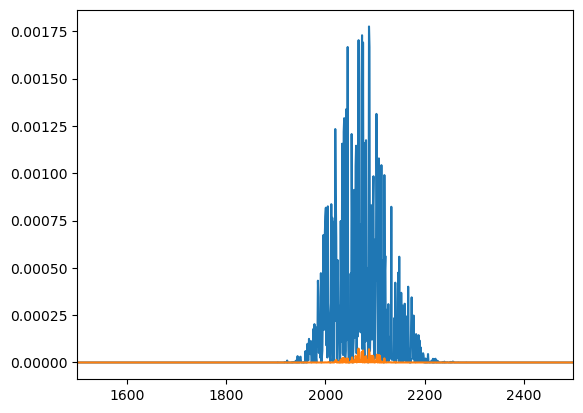

In [262]:
# plt.imshow(logps.T, vmin=-1000)
# plt.imshow(jnp.exp(logps).T, vmin=0.001)

# plt.colorbar()
# plt.plot((jnp.exp(logps12) - jnp.exp(logps1))[:,0]);

i = 0
plt.xlim(1500,2500)
plt.plot((jnp.exp(logps1))[:,i]);
plt.plot((jnp.exp(logps12))[:,i]);

In [ ]:
ys0 = camera_from_screen(uvs0[triplets[:,0]], intr)
ys1 = camera_from_screen(uvs1[triplets[:,1]], intr)
xs = triangulate_linear_hartley(Pose.id(), p1, ys0, ys1)

# cv2.solvePnPRansac(np.array(xs), np.array(uvs2[triplets[:,2]]), np.array(cam_K), None)

_, rot, trans, inlier = cv2.solvePnPRansac(np.array(xs), np.array(uvs2[triplets[:,2]]), np.array(cam_K), None, 
                                           iterationsCount=1_000, reprojectionError=2.01, confidence=0.99999, flags=cv2.SOLVEPNP_SQPNP)  


R = cv2.Rodrigues(rot)[0]
p2 = Pose.from_pos_matrix(trans[:,0], R).inv()


In [171]:

ys0 = camera_from_screen(uvs0[triplets[:,0]], intr)
ys1 = camera_from_screen(uvs1[triplets[:,1]], intr)
xs = triangulate_linear_hartley(Pose.id(), p1, ys0, ys1)

# cv2.solvePnPRansac(np.array(xs), np.array(uvs2[triplets[:,2]]), np.array(cam_K), None)

_, rot, trans, inlier = cv2.solvePnPRansac(np.array(xs), np.array(uvs2[triplets[:,2]]), np.array(cam_K), None, 
                                           iterationsCount=1_000, reprojectionError=2.01, confidence=0.99999, flags=cv2.SOLVEPNP_SQPNP)  


R = cv2.Rodrigues(rot)[0]
p2 = Pose.from_pos_matrix(trans[:,0], R).inv()



ys0 = camera_from_screen(uvs0[inds01[:,0]], intr)
ys1 = camera_from_screen(uvs1[inds01[:,1]], intr)
xs01 = triangulate_linear_hartley(Pose.id(), p1, ys0, ys1)

ys0 = camera_from_screen(uvs0[inds02[:,0]], intr)
ys1 = camera_from_screen(uvs2[inds02[:,1]], intr)
xs02 = triangulate_linear_hartley(Pose.id(), p2, ys0, ys1)


ys0 = camera_from_screen(uvs1[inds12[:,0]], intr)
ys1 = camera_from_screen(uvs2[inds12[:,1]], intr)
xs12 = triangulate_linear_hartley(p1, p2, ys0, ys1)


print(xq_cos(p1, cams[0].inv() @ cams[1]))
print(xq_cos(p2, cams[1].inv() @ cams[2]))

(Array(0.99953353, dtype=float32), Array(0.99998325, dtype=float32))
(Array(0.9991254, dtype=float32), Array(0.99514717, dtype=float32))


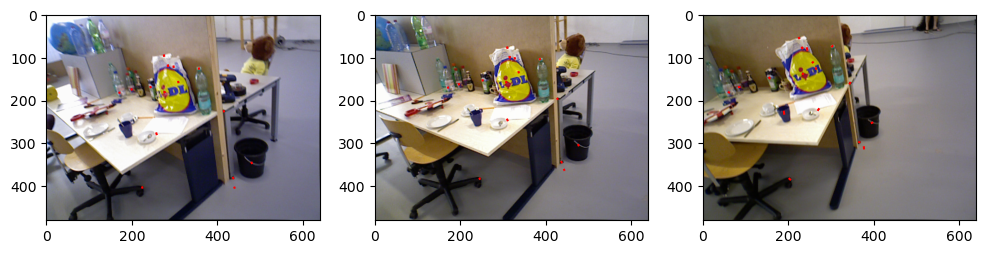

In [172]:
uvs0_ = screen_from_world(xs, Pose.id(), intr)
uvs1_ = screen_from_world(xs, p1, intr)
uvs2_ = screen_from_world(xs, p2, intr)


fig, axs = plt.subplots(1,3,figsize=(12,5))

ax = axs[0]
ax.set_xlim(0, intr.width)
ax.set_ylim(intr.height, 0)
ax.imshow(rgb[0])
ax.plot(np.stack([uvs0[triplets[:,0],0], uvs0_[:,0]]), np.stack([uvs0[triplets[:,0],1], uvs0_[:,1]]), c="r");


ax = axs[1]
ax.set_xlim(0, intr.width)
ax.set_ylim(intr.height, 0)
ax.imshow(rgb[1])
ax.plot(np.stack([uvs1[triplets[:,1],0], uvs1_[:,0]]), np.stack([uvs1[triplets[:,1],1], uvs1_[:,1]]), c="r");


ax = axs[2]
ax.set_xlim(0, intr.width)
ax.set_ylim(intr.height, 0)
ax.imshow(rgb[2])
# ax.scatter(uvs2[triplets[:,2],0] , uvs2[triplets[:,2],1], c=uvs1[triplets[:,1],0], cmap="rainbow", s=20)
ax.plot(np.stack([uvs2[triplets[:,2],0], uvs2_[:,0]]), np.stack([uvs2[triplets[:,2],1], uvs2_[:,1]]), c="r", zorder=1);


In [174]:

xs_true, cs_true, _ = data._get_colored_world_points(t0)

cs01  = vals_from_im(jnp.array(uvs0)[inds01[:,0]], jnp.array(rgb[0]))/255
cs02 = vals_from_im(jnp.array(uvs0)[inds02[:,0]], jnp.array(rgb[1]))/255
cs12 = vals_from_im(jnp.array(uvs1)[inds12[:,0]], jnp.array(rgb[2]))/255


# =============
rr.init("SfM")
rr.connect("127.0.0.1:8812")
rr.set_time_sequence("frame_idx", 0)


radii = .01
# rr.log(f"Triangulated", rr.Points3D(cams[0](xs), colors=[1.,1.,1.], radii=radii))


rr.log(f"World_true", rr.Points3D(xs_true, colors=cs_true, radii=radii))
rr.log(f"Triangulated_1", rr.Points3D(cams[0](xs01), colors=cs01, radii=radii))
rr.log(f"Triangulated_2", rr.Points3D(cams[0](xs02), colors=cs02, radii=radii))
rr.log(f"Triangulated_3", rr.Points3D(cams[0](p1(xs12)), colors=cs12, radii=radii))
log_pose("Pose[0]", cams[0], scale=.25, c=np.array([1.,0.,0.]))
log_pose("Pose[1]", cams[0]@p1, scale=.25, c=np.array([1.,0.,0.]))
log_pose("Pose[2]", cams[0]@p2, scale=.25, c=np.array([1.,0.,0.]))



log_pose("True[0]", cams[0], scale=0.1)
log_pose("True[1]", cams[1], scale=0.1)
log_pose("True[2]", cams[2], scale=0.1)

In [100]:
xq_cos(cams[0]@p1, cams[1])
xq_cos(cams[0]@p2, cams[2])

(Array(0.9999918, dtype=float32), Array(0.99925005, dtype=float32))

In [667]:
def func(t0, t1):
    rgb, depth, cams = data[[t0,t1]]
    (uvs0_all, fs0, inds0), (uvs1_all, fs1, inds1) = detect_and_match_sift_cv(rgb[0], rgb[1])
    uvs0 = uvs0_all[inds0]
    uvs1 = uvs1_all[inds1]
    p_cv, inlier_cv = infer_pose_and_inlier_cv(uvs0, uvs1, cam_K, prob=.9999, threshold=1.0, max_iters=1000)
    return {
        "rgb": rgb, 
        "depth": depth, 
        "cams": cams, 
        "inferred_pose": p_cv,
        "uvs0": uvs0,
        "uvs1": uvs1,
        "inlier": inlier_cv,
        "uvs0_all": uvs0_all,
        "uvs1_all": uvs1_all,
        "inds0": inds0,
        "inds1": inds1,
        }



dt = 40
# 2140
ts = [2140 + i*dt for i in range(3)]
objs = []
for (t0,t1) in zip(ts[:-1], ts[1:]):
    print(t0,t1)
    objs.append(func(t0, t1))

ps = [Pose.id()]
for p in [o["inferred_pose"] for o in objs]: 
    print(p)
    ps.append(ps[-1] @ p)
ps = Pose.stack_poses(ps)


cams = [objs[0]["cams"][0]]
for p in [o["cams"][1] for o in objs]: 
    cams.append(p)
cams = Pose.stack_poses(cams)

2140 2180
2180 2220
Pose(position=Array([ 0.17078036,  0.19642425, -0.96553165], dtype=float32), quaternion=Array([ 0.04088708, -0.19120288, -0.1727764 , -0.965359  ], dtype=float32))
Pose(position=Array([-0.19521505,  0.25438496, -0.9471957 ], dtype=float32), quaternion=Array([-0.02887738, -0.07093167, -0.06929317, -0.9946524 ], dtype=float32))


In [668]:
s0, s1 = jnp.linalg.norm( cams.pos[:-1] - cams.pos[1:], axis=1)
s0, s1

(Array(0.26454526, dtype=float32), Array(0.36130032, dtype=float32))

In [673]:
def get_angle(p, p1, p2):
    a = p1.pos - p.pos
    b = p2.pos - p.pos
    a = a/jnp.linalg.norm(a)
    b = b/jnp.linalg.norm(b)
    return jnp.arccos(jnp.dot(a,b))

def infer_and_angle(t0, t1, t2):
    p0 = Pose.id()
    p1 = func(t0, t1)["inferred_pose"]
    p2 = func(t0, t2)["inferred_pose"]
    return get_angle(p0, p1, p2), p1, p2

# def scale(p0, p1, p2, c = 1.):
#     alpha = get_angle(p0, p1, p2)
#     beta  = get_angle(p1, p0, p2)
#     gamma = jnp.pi - alpha - beta
#     a = jnp.sin(alpha) * c/jnp.sin(gamma)
#     b = jnp.sin(beta) * c/jnp.sin(gamma)
#     return a, b, (a+b)/2, np.sum([alpha, beta, gamma])


def scale_from_angles(alpha, beta, c=1):
    gamma = jnp.pi - alpha - beta
    a = jnp.sin(alpha) * c/jnp.sin(gamma)
    b = jnp.sin(beta)  * c/jnp.sin(gamma)
    return a,b


def scale_triplet(t0, t1, t2, s0=1):
    alpha, _,_ = infer_and_angle(t0, t1, t2)
    beta, _,_ = infer_and_angle(t1, t0, t2)

    print(alpha/jnp.pi, beta/jnp.pi)

    return scale_from_angles(alpha, beta, c=s0)


s1, scale_triplet(*ts, s0=s0)

0.118271254 0.63716793


(Array(0.36130032, dtype=float32),
 (Array(0.13821466, dtype=float32), Array(0.34588143, dtype=float32)))

In [614]:
s0, s1 = jnp.linalg.norm( cams.pos[:-1] - cams.pos[1:], axis=-1)
s0, s1

(Array(0.5186701, dtype=float32), Array(0.45296082, dtype=float32))

In [596]:
jnp.linalg.norm( ps.pos[1:] - ps.pos[:-1], axis=-1)

Array([1.       , 1.0000002], dtype=float32)

In [601]:

ps.shape



scale(ps[0], ps[1], ps[2], c= s0)

(Array(0.51867014, dtype=float32),
 Array(0.6730513, dtype=float32),
 Array(0.5958607, dtype=float32),
 3.1415925)

In [594]:
ps = [Pose.id()]
for p in [o["inferred_pose"] for o in objs]:
    ps.append(ps[-1] @ p)

ps = Pose.stack_poses(ps)
ps.shape

# =============
rr.init("SfM")
rr.connect("127.0.0.1:8812")
rr.set_time_sequence("frame_idx", 0)
rr.log(f"Triangulated", rr.Points3D(cams[0](xs), colors=[1.,1.,1.], radii=.05))
rr.log(f"Triangulated_inlier", rr.Points3D(cams[0](xs[inlier_cv]), colors=[1.,0.,1.], radii=.07))

log_pose("True[0]", objs[0]["cams"][0], scale=0.5)

for i,p in enumerate([o["cams"] for o in objs]):
    log_pose(f"True[{i+1}]", p[1], scale=.5)


for i,p in enumerate(ps):
    log_pose(f"Inf[{i}]", cams[0]@p, scale=0.5)

In [427]:
def random_choices(key, n, shape):
    _, keys = keysplit(key, 1, shape[0])
    return jax.vmap(lambda key: jax.random.choice(key, n, (shape[1],), replace=False))(keys)

In [428]:
def put_pose_on_S2(p):
    return Pose(p.pos/jnp.linalg.norm(p.pos), p.quat)

In [429]:
key = keysplit(key)
xs = jax.random.normal(key, (100_000,3))
xs = xs / jnp.linalg.norm(xs, axis=-1, keepdims=True)


In [430]:
def exp1(inds):
    ps = []
    for ii in inds:
        E = normalized_eight_point(ys0[ii], ys1[ii])
        p = recover_pose_cv(E, uvs0, uvs1, cam_K)
        ps.append(p)

    return Pose.stack_poses(ps)


def _exp2(ii, thresh=1.):

    E = normalized_eight_point(ys0[ii], ys1[ii])


    errs= epipolar_image_distances(E, ys0, ys1, cam_K, cam_K_inv)
    inlier =  errs < thresh
    # score = - jnp.(errs*inlier)/jnp.sum(inlier)
    score = jnp.sum(inlier)
    ps = poses_from_essential(E)
    # p,_ = find_best_chirality(ps, ys0, ys1)

    return E, ps, score*jnp.ones(4), jnp.ones(4)

exp2 = jax.jit(jax.vmap(_exp2, (0, None)))

def _exp3(ii, thresh=1.):

    E = normalized_eight_point(ys0[ii], ys1[ii], normalize=False, enforce_constraint=False)
    C,d = essential_constraints(E)

    errs= epipolar_image_distances(E, ys0, ys1, cam_K, cam_K_inv)
    inlier =  errs < thresh

    inlier_err = jnp.sum(errs*inlier)/jnp.sum(inlier)
    # score = - jnp.(errs*inlier)/jnp.sum(inlier)
    inlier_score = jnp.sum(inlier)
    ps = poses_from_essential(E)
    # p,_ = find_best_chirality(ps, ys0, ys1)

    score = inlier_score
    # score = -jnp.mean(C)
    # score = -jnp.abs(d) + inlier_score

    return E, ps, score*jnp.ones(4), jnp.mean(C)*jnp.ones(4)

exp3 = jax.jit(jax.vmap(_exp3, (0, None)))

In [431]:
%timeit -n 1 -r 1 infer_pose_using_cv(uvs0, uvs1, cam_K, prob=.9999, threshold=1., max_iters=1_000);

45.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


1.16 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Score 17.0 327.0
Err -0.102206476 0.06066178
(Array(0.99308336, dtype=float32), Array(0.99991405, dtype=float32))
(Array([-0.9828845 , -0.98286366,  0.9828845 ,  0.98286366], dtype=float32), Array([0.9999845 , 0.00279256, 0.9999845 , 0.00279256], dtype=float32))


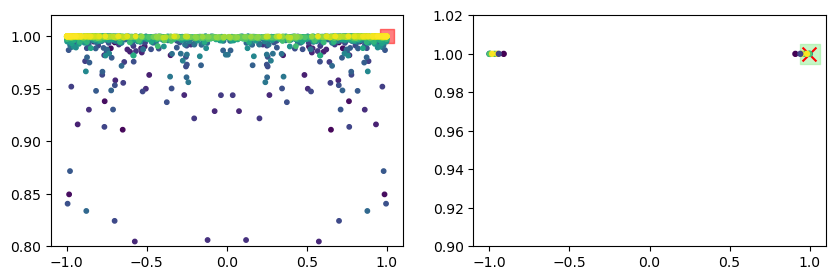

In [432]:

key = keysplit(key)
inds = random_choices(key, len(uvs0), (1_000, 8))


p_cv = infer_pose_using_cv(uvs0, uvs1, cam_K, prob=.9999, threshold=1.0, max_iters=1000)

%timeit -n 1 -r 1 jax.block_until_ready(exp3(inds, 10.));

Es, ps, scores, errs = exp3(inds, jnp.array(3.))
ps = ps.reshape(-1)
scores = scores.reshape(-1) 
errs = errs.reshape(-1)
perm = jnp.argsort(scores)

Es = Es[perm]
ps = ps[perm]
scores = scores[perm]
errs = errs[perm]




print("Score", scores.min(), scores.max())
print("Err", errs.min(), errs.max())
print(xq_cos(p_cv, p_true))
print(xq_cos(ps[-4:], p_true))

metric = xq_cos

fig, axs = plt.subplots(1,2,figsize=(10,3))

ax = axs[0]
# ax.set_xlim(0.5, 1.02)
ax.set_ylim(0.8, 1.02)
ax.scatter(1,1, s=100, c="r", marker="s", alpha=0.5)
ax.scatter(*metric(ps, p_true), s=10, c=scores, alpha=1., cmap="viridis")
# ax.scatter(*metric(ps, p_true), s=10, c=errs, alpha=1., cmap="viridis")
# ax.scatter(*metric(p_cv, p_true), s=100, c="r", marker="x")

ax = axs[1]
# ax.set_xlim(0.9, 1.02)
ax.set_ylim(0.9, 1.02)


k = 40
ax.scatter(1,1, s=200, c="lightgreen", marker="s", alpha=0.5)
ax.scatter(*metric(p_cv, p_true), s=100, c="r", marker="x")
ax.scatter(*metric(ps[-k:], p_true), s=50, c=-errs[-k:], marker=".");

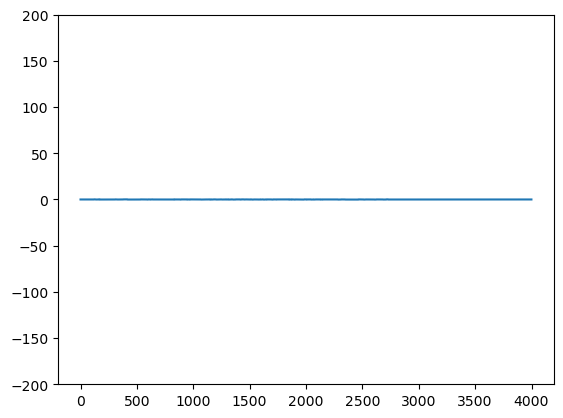

In [405]:
plt.ylim(-200,200)
plt.plot(errs)

In [409]:
def _translation_scores(x, q):
    E = essential_from_pose(Pose(x, q))
    inliers = epipolar_image_distances(E, ys0, ys1, cam_K, cam_K_inv) < 5.1
    score = jnp.sum(inliers)
    return score

translation_scores = jax.jit(jax.vmap(_translation_scores, (0, None)))



def _scorer(p):
    E = essential_from_pose(p)
    inliers = epipolar_image_distances(E, ys0, ys1, cam_K, cam_K_inv) < 2.1
    score = jnp.sum(inliers)
    return score

scorer = jax.jit(jax.vmap(_scorer))

-0.77, -0.97 ----  0.03,  0.00,
-0.77, -1.00 ----  1.00,  1.00,
 0.77,  0.98 ----  0.03,  0.02,
 0.77,  1.00 ----  1.00,  1.00,
-0.62, -0.67 ----  0.03,  0.04,
-0.62, -0.90 ----  0.99,  1.00,
 0.62,  0.68 ----  0.03,  0.02,
 0.62,  0.98 ----  0.99,  1.00,
-0.66, -0.91 ----  0.99,  1.00,
-0.66, -0.66 ----  0.05,  0.02,
 0.66,  0.89 ----  0.99,  1.00,
 0.66,  0.64 ----  0.05,  0.01,
-0.62, -0.65 ----  0.01,  0.02,
-0.62, -0.67 ----  0.99,  0.99,
 0.62,  0.68 ----  0.01,  0.02,
 0.62,  0.91 ----  0.99,  1.00,
-1.00, -1.00 ----  0.00,  0.01,
-1.00, -1.00 ----  1.00,  1.00,
 1.00,  1.00 ----  0.00,  0.01,
 1.00,  1.00 ----  1.00,  1.00,


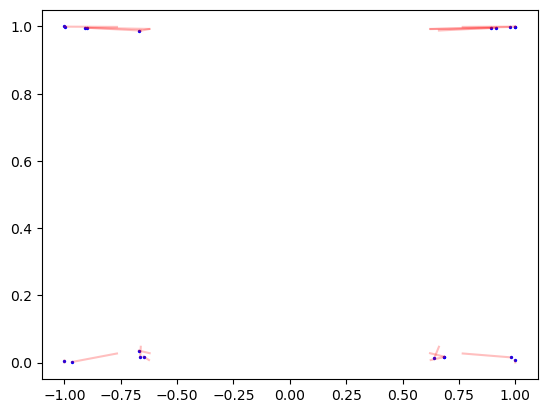

In [410]:
for p in ps[-20:]:

    dx = xq_cos(p, p_true)



    key, keys = keysplit(key, 1, 1_000_000)
    qs = vmap_uniform_pose(keys, p, .8, 0.05)
    scores = scorer(qs)
    p_  = qs[jnp.argmax(scores)]

    dx_ = xq_cos(p_, p_true)
    plt.scatter(dx_[0], dx_[1], c="b", s=2)
    plt.plot([dx[0], dx_[0]], [dx[1], dx_[1]], c="r", alpha=0.25)
    print(f"{dx[0]:>5.2f}, {dx_[0]:>5.2f} ---- {dx[1]:>5.2f}, {dx_[1]:>5.2f},")

In [373]:
q0 = ps[-4 + 1].quat

key, keys = keysplit(key, 1, 100_000)
qs = vmap_uniform_pose(keys, Pose(jnp.zeros(3), q0), 1., 0.1)



scores = scorer(qs)

%timeit -n 1 -r 1 jax.block_until_ready(scorer(qs));


p = qs[jnp.argmax(scores)]

print(xq_cos(p, p_true))
print(xq_cos(Pose(-p.pos, p.quat), p_true))
# print(xq_cos(Pose(-x, q), p_true))


3.03 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
(Array(0.9473765, dtype=float32), Array(0.9798653, dtype=float32))
(Array(-0.9473765, dtype=float32), Array(0.9798653, dtype=float32))


In [ ]:

key = keysplit(key)
inds = random_choices(key, len(uvs0), (2_000, 8))


p_cv = infer_pose_using_cv(uvs0, uvs1, cam_K, prob=.9999, threshold=1.0, max_iters=1000)

%timeit -n 1 -r 1 jax.block_until_ready(exp2(inds, 5.1));

Es, ps, scores = exp2(inds, jnp.array(1.))
ps = ps.reshape(-1)
scores = scores.reshape(-1) 
perm = jnp.argsort(scores)

Es = Es[perm]
ps = ps[perm]
scores = scores[perm]

qs = Pose.stack_poses([
    recover_pose_cv(E, uvs0, uvs1, cam_K) for E in Es[-20:]
])


print(xq_cos(p_cv, p_true))
print(xq_cos(ps[-4:], p_true))

metric = xq_cos

fig, axs = plt.subplots(1,2,figsize=(10,3))

ax = axs[0]
# ax.set_xlim(0.5, 1.02)
# ax.set_ylim(0.75, 1.02)
ax.scatter(1,1, s=100, c="r", marker="s", alpha=0.5)
ax.scatter(*metric(ps, p_true), s=10, c=scores, alpha=1., cmap="viridis")
# ax.scatter(*metric(p_cv, p_true), s=100, c="r", marker="x")

ax = axs[1]
# ax.set_xlim(0.9, 1.02)
ax.set_ylim(0.9, 1.02)


k = 100
ax.scatter(1,1, s=200, c="lightgreen", marker="s", alpha=0.5)
ax.scatter(*metric(p_cv, p_true), s=100, c="r", marker="x")
ax.scatter(*metric(ps[-k:], p_true), s=20, c=scores[-k:], marker=".");

In [311]:
import plotly.graph_objs as go
import numpy as np

# Assuming xs and cs are defined as numpy arrays
# xs should be of shape (N, 3)
# cs should be of shape (N,)

# Example data (replace with your actual data)
from jax.scipy.spatial.transform import Rotation as Rot



k = 200
euler_true = p_true.rot.as_euler("xyz")
# xs = ps[-k:].rot.as_euler("xyz")
xs = ps[-k:].quat[:,:3]
# xs = xs/jnp.linalg.norm(xs, axis=1)[:,None]
# xs = ps[-k:].pos
cs = metric(ps[-k:], p_true)[1]
# cs = scores[-k:]

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=xs[:, 0],  # X axis
    y=xs[:, 1],  # Y axis
    z=xs[:, 2],  # Z axis
    mode='markers',
    marker=dict(
        size=5,
        color=cs,  # Color based on cs array
        colorscale='jet',  # Color scale
        # opacity=0.8,
        cmin=0.98,
        cmax=1.0,
    )
)])

# Set the layout for the plot
fig.update_layout(
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
    margin=dict(l=0, r=0, b=0, t=0)  # Tight layout
)

# Display the plot
fig.show()

(array([ 304.,  636.,  864., 1084., 1276., 1200., 1176., 1160., 1292.,
        1108., 1012.,  828.,  768.,  584.,  736.,  520.,  496.,  480.,
         416.,  380.,  348.,  272.,  324.,  252.,  216.,  280.,  244.,
         192.,  192.,  180.,  116.,  184.,   96.,  136.,  100.,   52.,
          96.,   52.,   84.,   20.,   32.,   40.,   36.,   16.,   16.,
          20.,   16.,   36.,    8.,   16.,    4.,    4.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52., 53., 54., 55., 56., 57., 58., 59

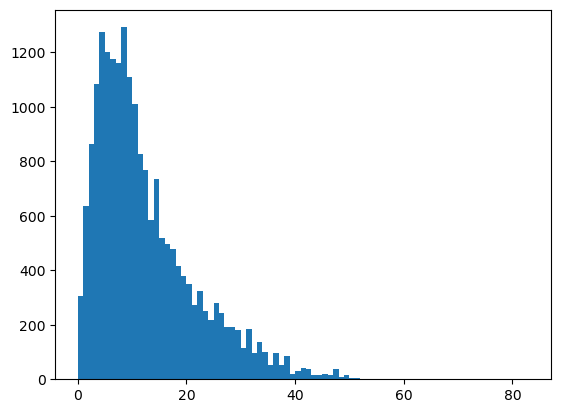

In [210]:
plt.hist(scores, bins=jnp.arange(len(uvs0)))

In [211]:

def _translation_scores(x, q):
    E = essential_from_pose(Pose(x, q))
    inliers = epipolar_image_distances(E, ys0, ys1, cam_K, cam_K_inv) < 5.1
    score = jnp.sum(inliers)
    return score

translation_scores = jax.jit(jax.vmap(_translation_scores, (0, None)))



def _scorer(p):
    E = essential_from_pose(p)
    inliers = epipolar_image_distances(E, ys0, ys1, cam_K, cam_K_inv) < 5.1
    score = jnp.sum(inliers)
    return score

scorer = jax.jit(jax.vmap(_scorer))

In [212]:
# xs = ps[-k:].quat[:,:3]

k = 5_000
xs = ps[-k:].rot.as_euler("xyz")
h, e = jax.numpy.histogramdd(xs, bins=[jnp.linspace(-jnp.pi*0.5, jnp.pi*0.5, 200)]*3)
e = jnp.stack(jnp.meshgrid(*e))
# h.shape
# quats = Rot.from_euler("xyz", xs).as_quat()

# plt.scatter(*metric(ps[-k:], p_true), s=20, c=scores[-k:], marker=".");
# qs.shape

jnp.argmax(h)

i = jnp.unravel_index(jnp.argmax(h), h.shape)
# e[:, i[0], i[1], i[2]]
e[:,*i]

xq_cos(Pose(jnp.ones(3), Rot.from_euler("xyz", e[:,*i]).as_quat()), p_true)
# xq_cos(Pose(jnp.ones(3), Rot.from_euler("xyz", e[:, i[0]+1, i[1]+1, i[2]+1]).as_quat()), p_true)



q0 = Rot.from_euler("xyz", e[:,*i]).as_quat()


print(xq_cos(Pose(jnp.zeros(3), q0), p_true))

(Array(nan, dtype=float32), Array(0.9809245, dtype=float32))


(Array(0.5536579, dtype=float32), Array(0.9806936, dtype=float32))
(Array(-0.5536579, dtype=float32), Array(0.9806936, dtype=float32))


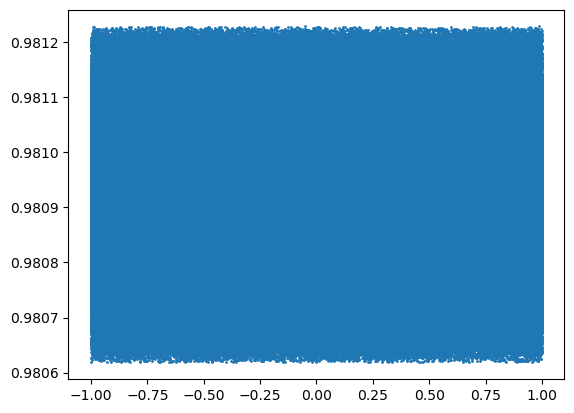

In [213]:



key, keys = keysplit(key, 1, 1_000_000)
qs = vmap_uniform_pose(keys, Pose(jnp.zeros(3), q0), 1., 0.001)


scores = scorer(qs)
p = qs[jnp.argmax(scores)]

# key = keysplit(key)
# xs = jax.random.normal(key, (1_000_000,3))
# xs = xs / jnp.linalg.norm(xs, axis=-1, keepdims=True)

# xs = xs.at[0].set(p_true.pos)

# print(xs.shape)



# %timeit -n 1 -r 1 jax.block_until_ready(translation_scores(xs, q));


# scores = translation_scores(xs, p_true.quat)
# x = xs[jnp.argmax(scores)]
# x = xs[0]

# print(scores[:10])


# print(xq_cos(Pose.id(), p_true))
# print(xq_cos(p_cv, p_true))
# print(xq_cos(Pose(x, q), p_true))
# print(xq_cos(Pose(-x, q), p_true))
# print(xq_cos(Pose(p_true.pos*0.1, q), p_true))


# plt.plot(scores[:40])

print(xq_cos(p, p_true))
print(xq_cos(Pose(-p.pos, p.quat), p_true))
# print(xq_cos(Pose(-x, q), p_true))

plt.scatter(*xq_cos(qs, p_true), s=1)

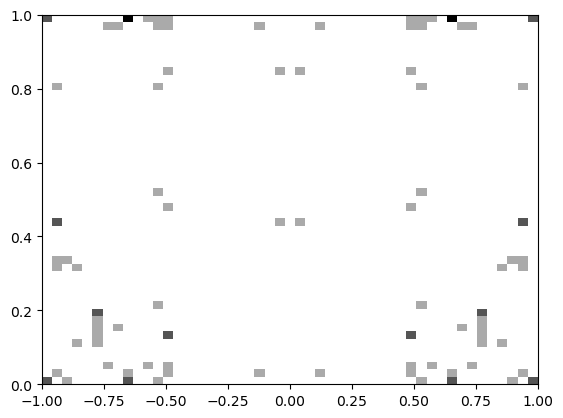

In [31]:
plt.hist2d(*metric(ps[-100:], p_true), 
           bins=[
               np.linspace(-1.,1.,50), 
               np.linspace(0.,1.,50)
            ], 
            cmap="binary");

# plt.scatter(*metric(p_cv, p_true), c="r", marker="x", clip_on=False);

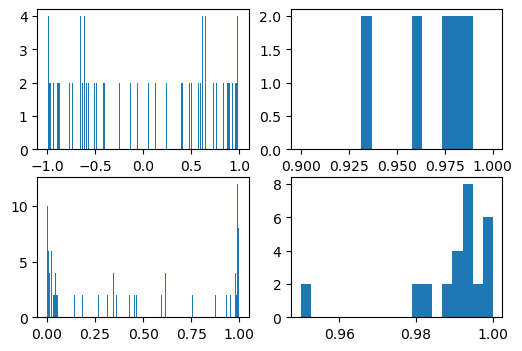

In [34]:
k = 100

fig, axs = plt.subplots(2,2,figsize=(6,4))
axs[0,0].hist(metric(ps[-k:], p_true)[0], bins=np.linspace(-1,1.,200));
axs[1,0].hist(metric(ps[-k:], p_true)[1], bins=np.linspace(0, 1.,200));

axs[0,1].hist(metric(ps[-k:], p_true)[0], bins=np.linspace(.9,1.,20));
axs[1,1].hist(metric(ps[-k:], p_true)[1], bins=np.linspace(.95,1.,20));

6.79 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


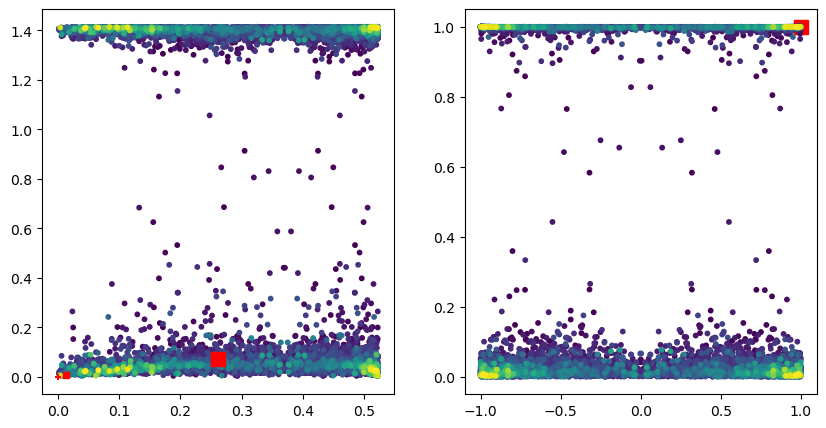

In [148]:

key = keysplit(key)
inds = random_choices(key, len(uvs0), (2500, 8))


p_cv = infer_pose_using_cv(uvs0, uvs1, cam_K, prob=.999999, threshold=1.0, max_iters=1000)
p_cv = rescale_pose(p_cv, p_true)

p_id = rescale_pose(Pose.id(), p_true)

%timeit -n 1 -r 1 jax.block_until_ready(exp2(inds));
ps2, errs = exp2(inds)
ps2 = ps2.reshape(-1)
errs = errs.reshape(-1) 
perm = jnp.argsort(errs)[:]
ps2 = ps2[perm]
errs = errs[perm]
ps2 = rescale_poses(ps2, p_true)



fig, axs = plt.subplots(1,2,figsize=(10,5))

axs[0].scatter(*jax.vmap(xq_dist, (0, None))(ps2, p_true), s=10, c=errs, alpha=1., cmap="viridis")

axs[0].scatter(0,0, s=20, c="r", marker="+")
axs[0].scatter(*xq_dist(p_cv, p_true), s=20, c="r", marker="s")
axs[0].scatter(*xq_dist(Pose.id(), p_true), s=100, c="r", marker="s")


axs[1].scatter(1,1, s=100, c="r", marker="s")
axs[1].scatter(*jax.vmap(xq_cos, (0, None))(ps2, p_true), s=10, c=errs, alpha=1., cmap="viridis")